Using TensorFlow backend.


   Unnamed: 0  internetActivity
0           1         50.341965
1           1         46.150144
2           1         35.053423
3           1         30.914044
4           1         31.978532


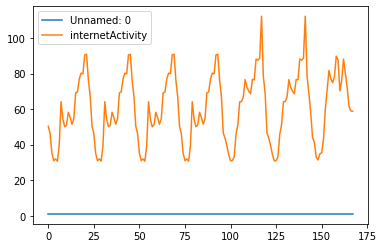

In [1]:
#https://github.com/ivanarielcaceres/timeseries-lstm-keras/blob/master/timeseries-prediction.ipynb
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np


df = pd.read_csv('g1.csv')
df=df.drop(['gridID','smsIn','smsOut','callIn','callOut'],axis=1)
print(df.head())
df.plot()


In [2]:

columns_to_keep = ['internetActivity']
df = df[columns_to_keep]
df['internetActivity'] = df['internetActivity'].apply(lambda x: x*1000)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 168


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,internetActivity
0,50341.965081
1,46150.143600
2,35053.423392
3,30914.043629
4,31978.532387


In [3]:
df.describe()

,internetActivity
count,168.000000
mean,60461.824013
std,19113.807660
min,30659.575234
25%,46150.143600
50%,59414.298365
75%,76521.612181
max,112291.185193


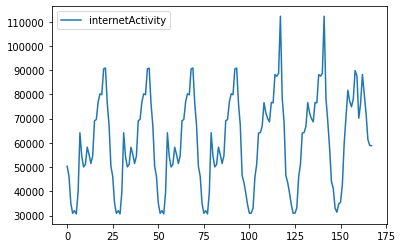

In [4]:
df.plot()

In [5]:
#null값
df.isnull().sum()

internetActivity    0
dtype: int64

In [6]:
print('Min', np.min(df))
print('Max', np.max(df))

Min internetActivity    30659.575234
dtype: float64
Max internetActivity    112291.185193
dtype: float64


In [8]:
dataset = df.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [9]:
print(scaled[:24])

[[0.24111236]
 [0.18976189]
 [0.05382533]
 [0.00311728]
 [0.01615743]
 [0.        ]
 [0.10992557]
 [0.41057335]
 [0.2916813 ]
 [0.23773589]
 [0.25012827]
 [0.33774603]
 [0.30072117]
 [0.25519926]
 [0.29313967]
 [0.47124411]
 [0.47775649]
 [0.56702197]
 [0.607746  ]
 [0.60294416]
 [0.73335397]
 [0.73801158]
 [0.55957094]
 [0.44668211]]


In [10]:
#Create RNN
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 117
test: 51


In [11]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [12]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

117 1
0
X 0 to 1
[0.24111236]
Y 1
0.1897618872684103
1
X 1 to 2
[0.18976189]
Y 2
0.05382532772535292
2
X 2 to 3
[0.05382533]
Y 3
0.0031172776749494036
3
X 3 to 4
[0.00311728]
Y 4
0.01615743159194205
4
X 4 to 5
[0.01615743]
Y 5
0.0
5
X 5 to 6
[0.]
Y 6
0.10992557106643236
6
X 6 to 7
[0.10992557]
Y 7
0.4105733532348416
7
X 7 to 8
[0.41057335]
Y 8
0.2916813006969741
8
X 8 to 9
[0.2916813]
Y 9
0.23773588751337765
9
X 9 to 10
[0.23773589]
Y 10
0.25012827418077516
10
X 10 to 11
[0.25012827]
Y 11
0.33774602991925246
11
X 11 to 12
[0.33774603]
Y 12
0.30072116981294433
12
X 12 to 13
[0.30072117]
Y 13
0.255199256677964
13
X 13 to 14
[0.25519926]
Y 14
0.2931396706122625
14
X 14 to 15
[0.29313967]
Y 15
0.47124410723269755
15
X 15 to 16
[0.47124411]
Y 16
0.47775648942992316
16
X 16 to 17
[0.47775649]
Y 17
0.5670219657326885
17
X 17 to 18
[0.56702197]
Y 18
0.6077460032554729
18
X 18 to 19
[0.607746]
Y 19
0.6029441605073338
19
X 19 to 20
[0.60294416]
Y 20
0.7333539651073804
20
X 20 to 21
[0.73335397]


In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(115, 1, 1)
(49, 1, 1)


In [14]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 0s - loss: 0.1125
Epoch 2/100
 - 0s - loss: 0.0535
Epoch 3/100
 - 0s - loss: 0.0503
Epoch 4/100
 - 0s - loss: 0.0470
Epoch 5/100
 - 0s - loss: 0.0446
Epoch 6/100
 - 0s - loss: 0.0428
Epoch 7/100
 - 0s - loss: 0.0402
Epoch 8/100
 - 0s - loss: 0.0377
Epoch 9/100
 - 0s - loss: 0.0369
Epoch 10/100
 - 0s - loss: 0.0321
Epoch 11/100
 - 0s - loss: 0.0306
Epoch 12/100
 - 0s - loss: 0.0252
Epoch 13/100
 - 0s - loss: 0.0272
Epoch 14/100
 - 0s - loss: 0.0223
Epoch 15/100
 - 0s - loss: 0.0198
Epoch 16/100
 - 0s - loss: 0.0196
Epoch 17/100
 - 0s - loss: 0.0178
Epoch 18/100
 - 0s - loss: 0.0176
Epoch 19/100
 - 0s - loss: 0.0162
Epoch 20/100
 - 0s - loss: 0.0151
Epoch 21/100
 - 0s - loss: 0.0144
Epoch 22/100
 - 0s - loss: 0.0130
Epoch 23/100
 - 0s - loss: 0.0136
Epoch 24/100
 - 0s - loss: 0.0127
Epoch 25/100
 - 0s - loss: 0.0123
Epoch 26/100
 - 0s - loss: 0.0119
Epoch 27/100
 - 0s - loss: 0.0123
Epoch 28/100
 - 0s - loss: 0.0121
Epoch 29/100
 - 0s - loss: 0.0120
Epoch 30/100
 - 0s - lo

In [15]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
col=['gridID','Internet Activity Prediction']
list1={'gridID':[1],'Internet Activity Prediction':[testScore]}
record=pd.DataFrame(list1)
record.to_csv('predictions.csv')

Train Score: 8557.80 RMSE
Test Score: 9952.92 RMSE


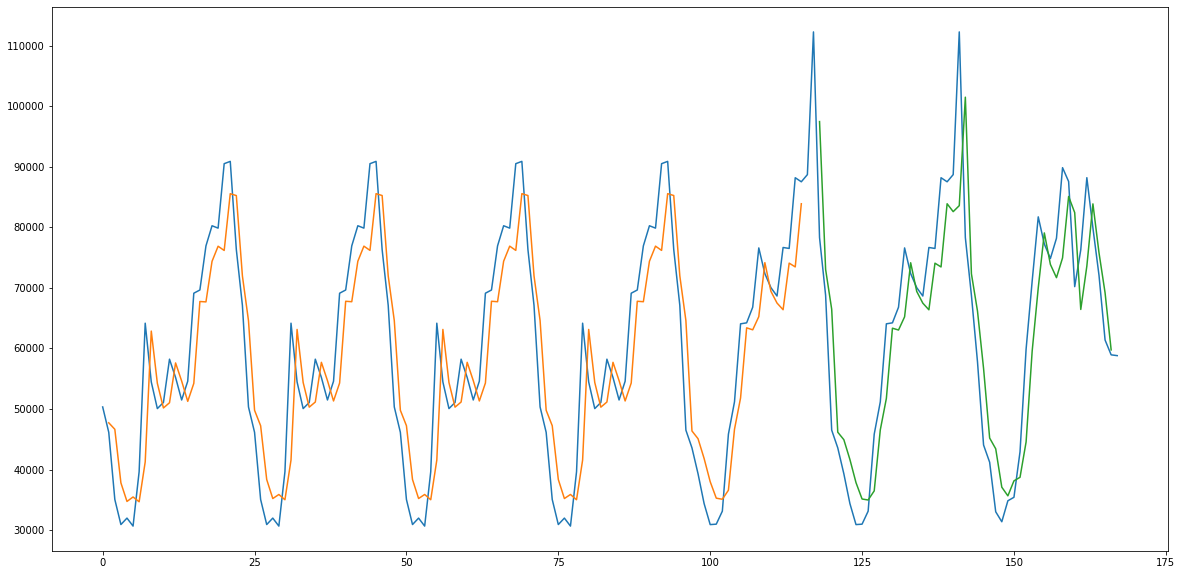

In [16]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()